In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import os
import matplotlib.colors as clrs
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.feature_selection import SelectKBest, f_classif

fp_ds1 = "./heart_failure_clinical_records_dataset.csv"
fp_ds2 = "./qsar_oral_toxicity.csv"
ds1 = pd.read_csv(fp_ds1, parse_dates=False, sep=',')
ds2 = pd.read_csv(fp_ds2, parse_dates=False, sep=';')
my_palette = {'yellow': '#ECD474', 'pale orange': '#E9AE4E', 'salmon': '#E2A36B', 'orange': '#F79522', 'dark orange': '#D7725E',
              'pale acqua': '#92C4AF', 'acqua': '#64B29E', 'marine': '#3D9EA9', 'green': '#10A48A', 'olive': '#99C244',
              'pale blue': '#BDDDE0', 'blue2': '#199ED5', 'blue3': '#1DAFE5', 'dark blue': '#0C70B2',
              'pale pink': '#D077AC', 'pink': '#EA4799', 'lavender': '#E09FD5', 'lilac': '#B081B9', 'purple': '#923E97',
              'white': '#FFFFFF', 'light grey': '#D2D3D4', 'grey': '#939598', 'black': '#000000'}

In [2]:
import datetime as dt

NR_COLUMNS: int = 3
HEIGHT: int = 4


def choose_grid(nr):
    if nr < NR_COLUMNS:
        return 1, nr
    else:
        return (nr // NR_COLUMNS, NR_COLUMNS) if nr % NR_COLUMNS == 0 else (nr // NR_COLUMNS + 1, NR_COLUMNS)


def set_axes(xvalues: list, ax: plt.Axes = None, title: str = '', xlabel: str = '', ylabel: str = '', percentage=False):
    if ax is None:
        ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(xvalues, fontsize='small', ha='center')

    return ax


def set_locators(xvalues: list, ax: plt.Axes = None):
    if isinstance(xvalues[0], dt.datetime):
        locator = mdates.AutoDateLocator()
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator, defaultfmt='%Y-%m-%d'))
    else:
        ax.set_xticks(xvalues)
        ax.set_xlim(xvalues[0], xvalues[-1])

    return ax


def plot_line(xvalues: list, yvalues: list, ax: plt.Axes = None, title: str = '', xlabel: str = '',
              ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax = set_locators(xvalues, ax=ax)
    ax.plot(xvalues,  yvalues, c=cfg.LINE_COLOR)


def multiple_line_chart(xvalues: list, yvalues: dict, ax: plt.Axes = None, title: str = '',
                        xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax = set_locators(xvalues, ax=ax)

    legend: list = []
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
    ax.legend(legend)


def bar_chart(xvalues: list, yvalues: list, ax: plt.Axes = None, title: str = '',
              xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax.bar(xvalues, yvalues, edgecolor=my_palette['dark blue'], color=my_palette['pale blue'])


def multiple_bar_chart(xvalues: list, yvalues: dict, ax: plt.Axes = None, title: str = '',
                       xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)

    x = np.arange(len(xvalues))  # the label locations

    width = 0.8 / (len(xvalues)*len(yvalues))
    # the width of the bars
    step = width / len(xvalues)
    i: int = 0
    for metric in yvalues:
        ax.bar(x + i*width, yvalues[metric], width=width, align='center', label=metric)
        i += 1
    ax.set_xticks(x + width/len(xvalues) - step/2)
    ax.legend(fontsize='x-small', title_fontsize='small')


def plot_confusion_matrix(cnf_matrix: np.ndarray, classes_names: np.ndarray,
                          ax: plt.Axes = None, normalize: bool = False):
    if ax is None:
        ax = plt.gca()
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix'
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=clrs.LinearSegmentedColormap.from_list("myCMPBlues", [my_palette['pale blue'], my_palette['blue2'], my_palette['blue3'], my_palette['dark blue']]))

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), color='w', horizontalalignment="center")


def plot_evaluation_results(labels: np.ndarray, trn_y, prd_trn, tst_y, prd_tst):
    cnf_mtx_trn = metrics.confusion_matrix(trn_y, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tst_y, prd_tst, labels)
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

    evaluation = {'Accuracy': [(tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn),
                               (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)],
                  'Recall': [tp_trn / (tp_trn + fn_trn), tp_tst / (tp_tst + fn_tst)],
                  'Specificity': [tn_trn / (tn_trn + fp_trn), tn_tst / (tn_tst + fp_tst)],
                  'Precision': [tp_trn / (tp_trn + fp_trn), tp_tst / (tp_tst + fp_tst)]}

    fig, axs = plt.subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets")
    plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1])


def plot_roc_chart(models: dict, tstX: np.ndarray, tstY: np.ndarray, ax: plt.Axes = None, target: str = 'class'):
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('ROC chart for %s' % target)

    ax.plot([0, 1], [0, 1], color='navy', label='random', linewidth=1, linestyle='--',  marker='')
    for clf in models.keys():
        metrics.plot_roc_curve(models[clf], tstX, tstY, ax=ax, marker='', linewidth=1)
    ax.legend(loc="lower right")

In [3]:
sb_vars = ds2.select_dtypes(include='object')
ds2[sb_vars.columns] = ds2.select_dtypes(['object']).apply(lambda x: x.astype('category'))

cols_nr = ds2.select_dtypes(include='number')
cols_sb = ds2.select_dtypes(include='category')

ds2.describe(include='all')

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.962,0.963,0.964,0.965,0.966,0.967,0.968,0.969,0.970,negative
count,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,...,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,negative
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8250
mean,0.212991,0.035702,0.068735,0.033367,0.018685,0.144811,0.123123,0.193749,0.013792,0.017351,...,0.061284,0.016683,0.164387,0.239017,0.022467,0.022022,0.021800,0.022356,0.018463,NaN
std,0.409444,0.185557,0.253018,0.179602,0.135419,0.351930,0.328597,0.395257,0.116631,0.130582,...,0.239863,0.128089,0.370647,0.426507,0.148205,0.146763,0.146037,0.147846,0.134626,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


Size of dataset before oversampling: 8991


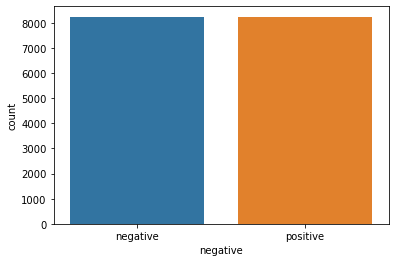

In [4]:
!pip install imblearn  
from imblearn.over_sampling import SMOTE
oversampling_func = SMOTE(random_state=42)
X = ds2.iloc[:,:-1]
y = ds2[["negative"]]
print("Size of dataset before oversampling: "+str(len(X)))
X_smote, y_smote = oversampling_func.fit_resample(X, y)
smote_dataset = pd.concat((X_smote,y_smote),axis=1)
sns.countplot(x="negative", data=smote_dataset)
#exprimentar diferentes estratégias aqui. TIpo 3000/3000 etc

In [5]:
dummy = pd.get_dummies(smote_dataset.negative, prefix='neg_').iloc[:,:1]
result = pd.concat([smote_dataset, dummy], axis = 1)
result

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.963,0.964,0.965,0.966,0.967,0.968,0.969,0.970,negative,neg__negative
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,negative,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,negative,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,negative,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,negative,1
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,negative,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,positive,0
16496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,positive,0
16497,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,positive,0
16498,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,positive,0


In [6]:
result.pop('negative')

0        negative
1        negative
2        negative
3        negative
4        negative
           ...   
16495    positive
16496    positive
16497    positive
16498    positive
16499    positive
Name: negative, Length: 16500, dtype: category
Categories (2, object): [negative, positive]

In [7]:
result.drop_duplicates(keep='first', inplace=True)

so = result.corr().unstack().sort_values(ascending = False).drop_duplicates()
print(so[:10])
print(so[-10:])

neg__negative  neg__negative    1.000000
1.41           1.19             0.984254
1.14           1.48             0.976748
1.37           1.44             0.975093
0.247          0.646            0.974240
1.40           1.34             0.972211
0.775          0.434            0.971984
0.404          0.332            0.969487
1.6            1.18             0.968838
1.40           1.44             0.966527
dtype: float64
0.469          1.40            -0.238050
1.3            0.469           -0.238518
0.247          0.311           -0.239663
0.469          1.48            -0.242939
neg__negative  0.605           -0.245874
0.469          1.34            -0.247951
neg__negative  0.35            -0.248381
1.14           0.469           -0.250859
0.561          neg__negative   -0.295344
neg__negative  0.268           -0.340950
dtype: float64


In [8]:
corr = result.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
len(to_drop)

38

In [9]:
result.drop(result[to_drop], axis = 1, inplace = True)
print(ds2.shape[1] - result.shape[1])
result.drop_duplicates()

38


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.961,0.962,0.963,0.965,0.966,0.967,0.968,0.969,0.970,neg__negative
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16442,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16444,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16463,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16487,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


/home/aid/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


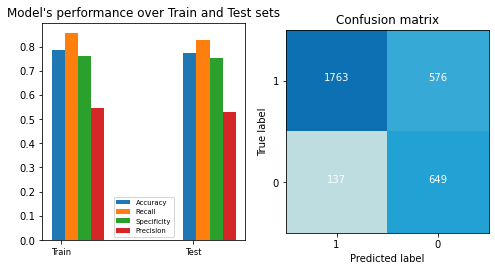

In [10]:
y: np.ndarray = result.pop('neg__negative').values
X: np.ndarray = result.values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

clf = GaussianNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)
#fazer accuracy antes de balancear

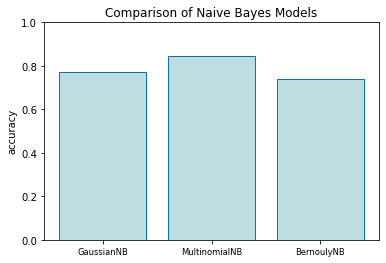

In [13]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulyNB': BernoulliNB()}

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

<ipython-input-2-2e695a534b54>:36: UserWarning: Attempting to set identical left == right == 15 results in singular transformations; automatically expanding.
  ax.set_xlim(xvalues[0], xvalues[-1])


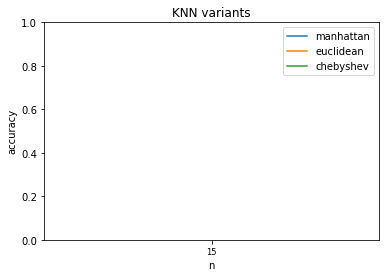

Best results with 15 neighbors and chebyshev


In [12]:
nvalues = [15] #isto não faz sentido. VAriar entre impares
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues

plt.figure()
multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))